# Шаг 1. Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Шаг 2. Импорт данных

Все три файла содержат числовые данные, сгенерированные по разным распределениям.  
Загружаем их в цикле, обрабатываем возможные ошибки (отсутствие файла, некорректный формат).


In [2]:
def load_single_line_csv(filename: str) -> pd.DataFrame:
    try:
        with open(filename, "r", encoding="utf-8") as f:
            line = f.readline().strip()
    except FileNotFoundError:
        print(f"Файл '{filename}' не найден.")
        return pd.DataFrame()

    try:
        values = [float(x) for x in line.split(",")]
    except ValueError as e:
        print(f"Некорректный формат данных в '{filename}': {e}")
        return pd.DataFrame()

    return pd.DataFrame(values, columns=["Value"])

files = ["set_1.csv", "set_2.csv", "set_3.csv"]
dfs = {}

for file in files:
    df = load_single_line_csv(file)
    if df.empty:
        print(f"Предупреждение: '{file}' не был загружен или пуст.")
    else:
        dfs[file] = df
        print(f"Файл '{file}' загружен. Кол-во значений: {len(df)}")

Файл 'set_1.csv' загружен. Кол-во значений: 100000
Файл 'set_2.csv' загружен. Кол-во значений: 10000
Файл 'set_3.csv' загружен. Кол-во значений: 100000


Для удаления выбросов будем использовать медиану и медианное абсолютное отклонение (MAD).

In [3]:
def remove_outliers_mad(data: np.ndarray, threshold: float = 3) -> np.ndarray:
    if len(data) < 2:
        return data  
    
    median = np.median(data)
    absolute_deviation = np.abs(data - median)
    
    mad = np.median(absolute_deviation)
    
    lower_bound = median - threshold * mad
    upper_bound = median + threshold * mad
    
    mask = (data >= lower_bound) & (data <= upper_bound)
    return data[mask]

for file in files:
    if file in dfs and not dfs[file].empty and "Value" in dfs[file].columns:
        original_len = len(dfs[file])
        
        filtered_values = remove_outliers_mad(dfs[file]["Value"].values)
        
        dfs[file] = pd.DataFrame(filtered_values, columns=["Value"])
        
        removed = original_len - len(filtered_values)
        print(f"Файл '{file}': {len(filtered_values)} значений после удаления выбросов "
              f"(изначально {original_len}), удалено {removed}.")
    else:
        print(f"Предупреждение: Файл '{file}' отсутствует, пуст или не содержит столбец 'Value'.")

Файл 'set_1.csv': 82637 значений после удаления выбросов (изначально 100000), удалено 17363.
Файл 'set_2.csv': 9421 значений после удаления выбросов (изначально 10000), удалено 579.
Файл 'set_3.csv': 87395 значений после удаления выбросов (изначально 100000), удалено 12605.


# Шаг 3. Анализ данных: математическое ожидание и несмещенная дисперсия

**Задачи:**

1. Реализовать функцию для расчета математического ожидания (среднего) набора чисел без использования встроенных методов.
2. Реализовать функцию для расчета несмещенной дисперсии по формуле:

$$
s^2 = \frac{1}{n-1} \sum_{i=1}^{n} \left(x_i - \bar{x}\right)^2
$$

где $\bar{x}$ — среднее арифметическое, а $n$ — число наблюдений.

Затем также тестирование провести тестирование.


In [4]:
def calculate_mean(data):
    total = 0.0
    count = 0
    for x in data:
        total += x
        count += 1
    if count == 0:
        return 0
    return total / count

def calculate_unbiased_variance(data):
    count = 0
    for _ in data:
        count += 1
    if count < 2:
        return 0
    mean_val = calculate_mean(data)
    sum_sq = 0.0
    for x in data:
        sum_sq += (x - mean_val) ** 2
    return sum_sq / (count - 1)

if "set_2.csv" in dfs:
    sample_data = []
    for i, value in enumerate(dfs["set_2.csv"]["Value"]):
        if i >= 10:
            break
        sample_data.append(value)

    print("Тестовая выборка (5 наблюдений):", sample_data)
    print("Среднее:", calculate_mean(sample_data))
    print("Несмещённая дисперсия:", calculate_unbiased_variance(sample_data))
else:
    print("Датасет set_1.csv не загружен для тестирования.")


Тестовая выборка (5 наблюдений): [90.547448, 80.548716, 92.992958, 33.050472, 142.98364, -100.226411, 57.025498, 97.936745, -5.646959, -117.066173]
Среднее: 37.2145934
Несмещённая дисперсия: 7516.360614005314


# Шаг 4. Построение доверительных интервалов

Искомый интервал $(\underline{\theta}, \overline{\theta})$ ищется по формулам:
$$\underline{\theta}=\bar{x}_B - \frac{t_{n-1} \cdot s}{\sqrt{n}}$$

$$\overline{\theta}=\bar{x}_B + \frac{t_{n-1} \cdot s}{\sqrt{n}}$$


set_1.csv
Доверительный интервал для мат. ожидания: (2.318, 2.336)
Мат. ожидания: 2.327
Доверительный интервал для дисперсии: (1.694, 1.727)
Дисперсии: 1.710


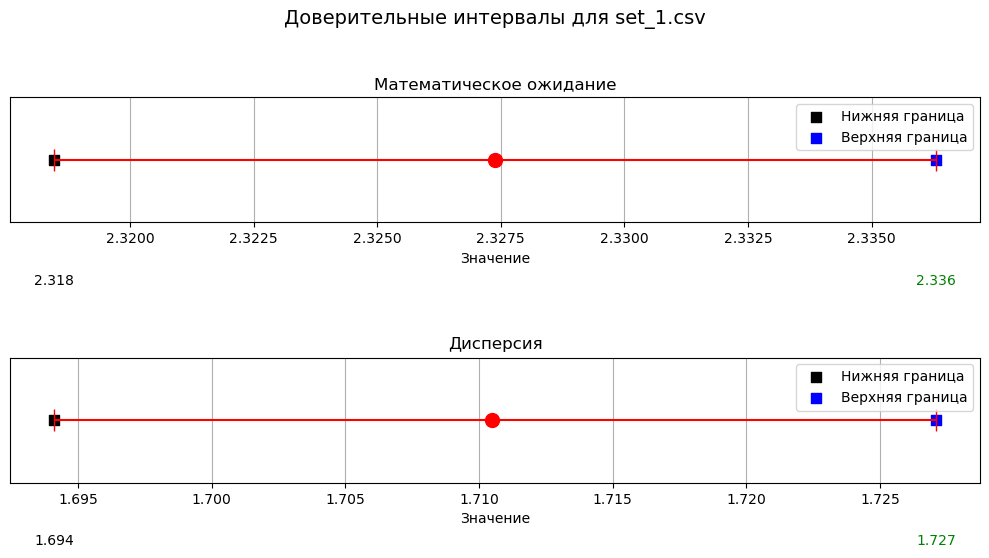


set_2.csv
Доверительный интервал для мат. ожидания: (17.349, 20.394)
Мат. ожидания: 18.872
Доверительный интервал для дисперсии: (5525.608, 5850.420)
Дисперсии: 5684.520


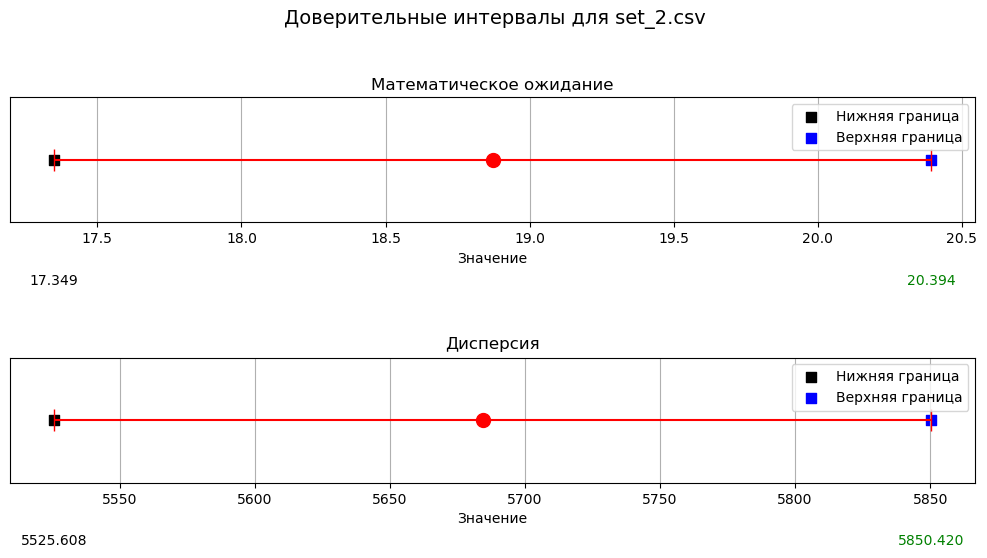


set_3.csv
Доверительный интервал для мат. ожидания: (0.088, 0.089)
Мат. ожидания: 0.089
Доверительный интервал для дисперсии: (0.005, 0.005)
Дисперсии: 0.005


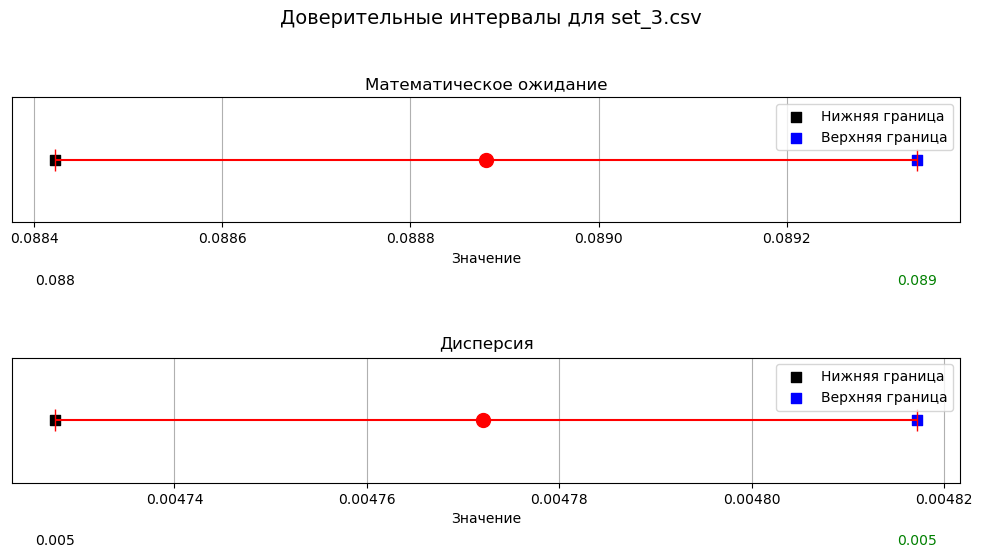

In [5]:
from scipy.stats import t, chi2

def student_confidence_mean_interval(arr, confidence=0.95):
    std = calculate_unbiased_variance(arr) ** 0.5  # Стандартное отклонение
    mean = calculate_mean(arr)  # Среднее значение
    n = len(arr)  # Размер выборки
    df = n - 1  # Степени свободы
    alpha = 1 - confidence  # Уровень значимости
    z = t.ppf(1 - alpha / 2, df)  # Критическое значение t-распределения
    delta = z * std / (n ** 0.5)  # Погрешность
    lower = mean - delta  # Нижняя граница
    upper = mean + delta  # Верхняя граница
    return mean, (lower, upper)

def confidence_variance_interval(arr, confidence=0.95):
    n = len(arr)
    df = n - 1
    alpha = 1 - confidence  # Уровень значимости
    var = calculate_unbiased_variance(arr)  # Несмещённая дисперсия
    chi2_lower = chi2.ppf(alpha / 2, df)  # Нижнее критическое значение хи-квадрат
    chi2_upper = chi2.ppf(1 - alpha / 2, df)  # Верхнее критическое значение хи-квадрат
    lower = df * var / chi2_upper  # Нижняя граница
    upper = df * var / chi2_lower  # Верхняя граница
    return var, (lower, upper)
import matplotlib.pyplot as plt

for file in files:
    if file in dfs:
        data = dfs[file]["Value"]
        mean_val, (mean_lower, mean_upper) = student_confidence_mean_interval(data, confidence=0.95)
        var_val, (var_lower, var_upper) = confidence_variance_interval(data, confidence=0.95)

        print(f"\n{file}")
        print(f"Доверительный интервал для мат. ожидания: ({mean_lower:.3f}, {mean_upper:.3f})")
        print(f"Мат. ожидания: {mean_val:.3f}")
        print(f"Доверительный интервал для дисперсии: ({var_lower:.3f}, {var_upper:.3f})")
        print(f"Дисперсии: {var_val:.3f}")

        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=False)
        fig.suptitle(f"Доверительные интервалы для {file}", fontsize=14)

        axs[0].errorbar(x=mean_val, y=0, xerr=[[mean_val - mean_lower], [mean_upper - mean_val]], fmt='o', capsize=8, markersize=10, color='red')
        axs[0].scatter(mean_lower, 0, color='black', marker='s', s=50, label="Нижняя граница")
        axs[0].scatter(mean_upper, 0, color='blue', marker='s', s=50, label="Верхняя граница")
        axs[0].text(mean_lower, -0.1, f"{mean_lower:.3f}", ha="center", va="top", color="black", fontsize=10)
        axs[0].text(mean_upper, -0.1, f"{mean_upper:.3f}", ha="center", va="top", color="green", fontsize=10)
        axs[0].set_title("Математическое ожидание")
        axs[0].set_yticks([])
        axs[0].set_xlabel("Значение")
        axs[0].legend(loc='best')
        axs[0].grid(True, axis='x')

        axs[1].errorbar(x=var_val, y=0, xerr=[[var_val - var_lower], [var_upper - var_val]], fmt='o', capsize=8, markersize=10, color='red')
        axs[1].scatter(var_lower, 0, color='black', marker='s', s=50, label="Нижняя граница")
        axs[1].scatter(var_upper, 0, color='blue', marker='s', s=50, label="Верхняя граница")
        axs[1].text(var_lower, -0.1, f"{var_lower:.3f}", ha='center', va='top', color='black', fontsize=10)
        axs[1].text(var_upper, -0.1, f"{var_upper:.3f}", ha='center', va='top', color='green', fontsize=10)
        axs[1].set_title("Дисперсия")
        axs[1].set_yticks([])
        axs[1].set_xlabel("Значение")
        axs[1].legend(loc='best')
        axs[1].grid(True, axis='x')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    else:
        print(f"{file}: Данные отсутствуют.")

## Шаг 5. Генерация теоретических распределений

1. Определим подходящее теоретическое распределение для каждого набора данных:
   - set_1.csv: геометрическое распределение.
   - set_2.csv: нормальное распределение.
   - set_3.csv: экспоненциальное распределение.

2. Реализуем функции генерации данных для стандартных распределений:

3. Строим графики гистограмм теоретических распределений и сравниваем их с гистограммами эмпирических данных.


set_1.csv
Среднее: 2.327
Дисперсия: 1.710
Оценка p: 0.430


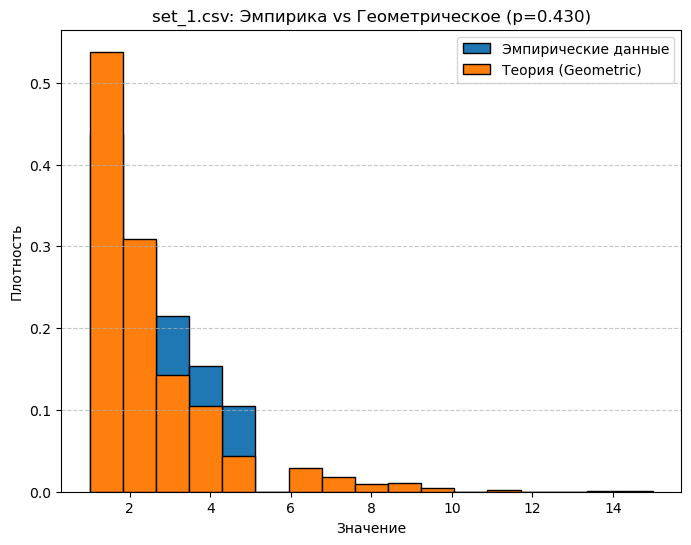


set_2.csv
Среднее: 18.872
Дисперсия: 5684.520
Оценка μ: 18.872, σ: 75.396


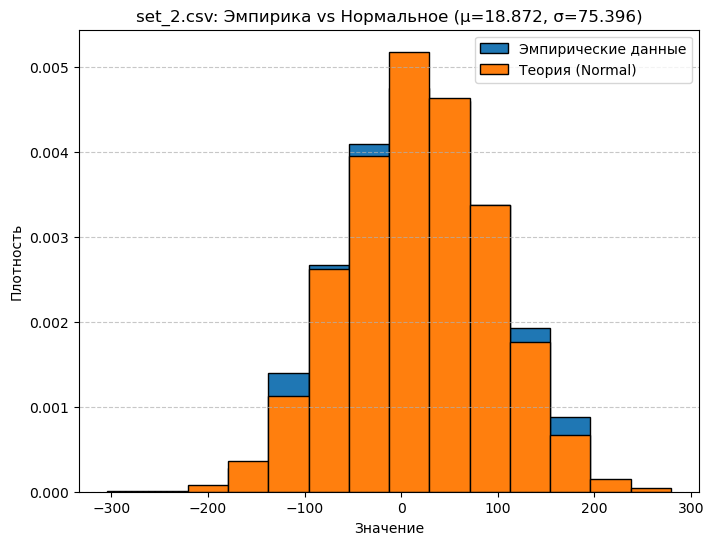


set_3.csv
Среднее: 0.089
Дисперсия: 0.005
Оценка λ: 11.251


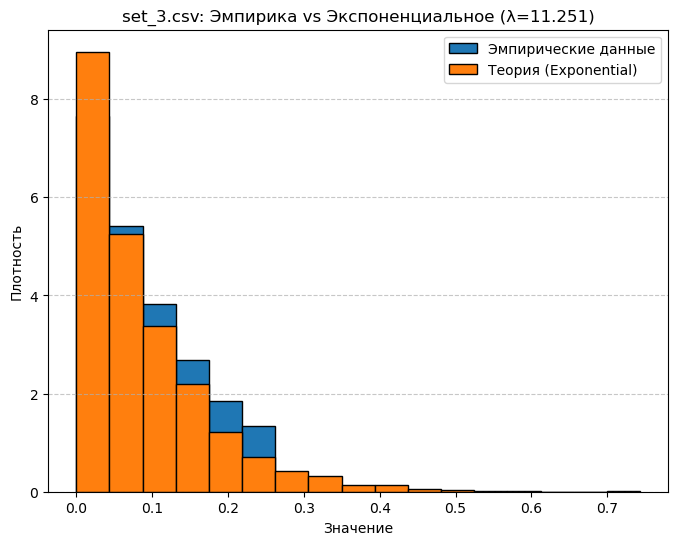

In [20]:
DEFAULT_COLORS = ["#1f77b4", "#ff7f0e"]
DEFAULT_ALPHAS = [1, 1]
FIGURE_SIZE = (8, 6)
SAMPLE_SIZES = {
    "geometric": 2000,
    "normal": 5000,
    "exponential": 3000
}

def calculate_sturges_bins(data):
    n = len(data)
    return 1 if n <= 1 else math.ceil(1 + math.log2(n))

def generate_geometric(p, size=1000):
    return np.random.geometric(p, size=size)

def generate_normal(mu, sigma, size=1000):
    return np.random.normal(mu, sigma, size=size)

def generate_exponential(lam, size=1000):
    return np.random.exponential(1.0 / lam, size=size)

def plot_histograms(data_sets, title, labels=None, alphas=None, colors=None):
    if labels is None:
        labels = [f"Data {i+1}" for i in range(len(data_sets))]
    if alphas is None:
        alphas = DEFAULT_ALPHAS
    if colors is None:
        colors = DEFAULT_COLORS

    valid_data = []
    valid_labels = []
    valid_alphas = []
    for data, label, alpha in zip(data_sets, labels, alphas):
        arr = np.array(data)
        if len(arr) > 0:
            valid_data.append(arr)
            valid_labels.append(label)
            valid_alphas.append(alpha)
        else:
            print(f"Пропуск пустого набора: {label}")

    if not valid_data:
        print(f"{title}: Все наборы данных пустые. График не построен.")
        return

    all_data = np.concatenate(valid_data)
    bins_count = calculate_sturges_bins(all_data)
    bins = np.linspace(all_data.min(), all_data.max(), bins_count)

    plt.figure(figsize=FIGURE_SIZE)
    for i, data in enumerate(valid_data):
        plt.hist(
            data,
            bins=bins,
            density=True,
            alpha=valid_alphas[i],
            color=colors[i % len(colors)],
            edgecolor="black",
            label=valid_labels[i],
            histtype="bar"
        )

    plt.title(title)
    plt.xlabel("Значение")
    plt.ylabel("Плотность")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def process_dataset(file, distribution_type, dfs):
    if file not in dfs:
        print(f"{file}: Данные отсутствуют. Пропуск.")
        return

    data = dfs[file]["Value"].values
    mean = calculate_mean(data)
    variance = calculate_unbiased_variance(data)

    print(f"\n{file}")
    print(f"Среднее: {mean:.3f}")
    print(f"Дисперсия: {variance:.3f}")

    if distribution_type == "geometric":
        if mean <= 1:
            print(f"Среднее ({mean:.3f}) <= 1. Невозможно оценить геометрическое распределение.")
            return
        p_est = 1.0 / mean
        theo_data = generate_geometric(p_est, size=SAMPLE_SIZES["geometric"])
        title = f"{file}: Эмпирика vs Геометрическое (p={p_est:.3f})"
        print(f"Оценка p: {p_est:.3f}")

    elif distribution_type == "normal":
        mu_est = mean
        sigma_est = math.sqrt(variance) if variance > 0 else 0.0
        theo_data = generate_normal(mu_est, sigma_est, size=SAMPLE_SIZES["normal"])
        title = f"{file}: Эмпирика vs Нормальное (μ={mu_est:.3f}, σ={sigma_est:.3f})"
        print(f"Оценка μ: {mu_est:.3f}, σ: {sigma_est:.3f}")

    else:
        positive_data = data[data >= 0]
        if len(positive_data) == 0:
            print("Нет положительных значений. Пропуск экспоненциальной аппроксимации.")
            return
        mean_positive = calculate_mean(positive_data)
        if mean_positive == 0:
            print("Среднее положительных значений равно 0. Пропуск.")
            return
        lam_est = 1.0 / mean_positive
        theo_data = generate_exponential(lam_est, size=SAMPLE_SIZES["exponential"])
        title = f"{file}: Эмпирика vs Экспоненциальное (λ={lam_est:.3f})"
        print(f"Оценка λ: {lam_est:.3f}")

    plot_histograms(
        data_sets=[data, theo_data],
        title=title,
        labels=["Эмпирические данные", f"Теория ({distribution_type.capitalize()})"],
        alphas=DEFAULT_ALPHAS,
        colors=DEFAULT_COLORS
    )

DATASETS = [
    ("set_1.csv", "geometric"),
    ("set_2.csv", "normal"),
    ("set_3.csv", "exponential")
]

for file, dist_type in DATASETS:
    process_dataset(file, dist_type, dfs)

На основании сравнения графиков можем выдвинуть 3 гипотезы о соответствии набора данных определенному распределению:

|Набор данных|Распределение|
|-|-|
|1|Экспоненциальное|
|2|Нормальное|
|3|Экспоненциальное|

# Шаг 6. Проверка гипотез

## Критерий Колмогорова–Смирнова
Критерий Колмогорова–Смирнова оценивает максимальное отклонение между эмпирической функцией распределения выборки $ F_n(x) $ и теоретической $ F(x) $:  
$$
D_n = \sup_{x \in \mathbb{R}} |F_n(x) - F(x)| 
$$
Используется для проверки, соответствует ли выборка заданному распределению или совпадают ли распределения двух выборок.

## Расчёт p-value
p-value — это вероятность получить результат, равный или более экстремальный, чем наблюдаемый, при верной нулевой гипотезе. Оно вычисляется на основе тестовой статистики и помогает определить, отвергать ли гипотезу $(p-value < (\alpha)$, обычно 0.05).

## $\chi^2$-критерий
Критерий хи-квадрат сравнивает наблюдаемые частоты с ожидаемыми по теоретическому распределению. Статистика:  
$$
\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}
$$
Применяется для проверки соответствия распределения или независимости категориальных переменных.

In [7]:
def kolmogorov_statistic(empirical_function, data, theoretical_function, *args):
    n = len(data)
    return max(abs(empirical_function(data[i], data) - theoretical_function(data[i], *args)) for i in range(n))

def kolmogorov_criterion(dn: float, n: float, K_a: float):
    crit = math.sqrt(n) * dn
    return crit, crit < K_a

Функции распределения

In [8]:
def exponential_distribution_function(x: float, mean: float):
    lam = 1 / mean
    return 1 - math.exp(-lam * x)

def normal_distribution_function(x: float, mean: float, std: float):
    return 1/2 * (1 + math.erf((x - mean) / (std * math.sqrt(2))))

def geometric_distribution_function(x: float, mean: float) -> float:
    if mean <= 1:
        return 0.0
    if x < 1:
        return 0.0
    p = 1 / mean
    return 1 - (1 - p) ** math.floor(x)

def empirical_distribution_function(x: float, sorted_data: np.ndarray):
    count = np.searchsorted(sorted_data, x, side='left')
    return count / len(sorted_data)

Сортируем данные в порядке неубывания эмпирические данные


In [9]:
def sort_dfs_values(dfs: dict) -> dict:
    for file, df in dfs.items():
        if not df.empty and "Value" in df.columns:
            dfs[file] = df.sort_values(by="Value", ascending=True).reset_index(drop=True)
        else:
            print(f"Предупреждение: DataFrame для '{file}' пуст или не содержит столбец 'Value'.")
    return dfs

dfs = sort_dfs_values(dfs)

In [10]:
K = 1.73

Проведем тест для первого файла, также будем производить вычисление p-value для полученных результатов, используя аппроксимацию Смирнова

$$p \approx 1 - 2\sum_{k = 1}^{\infty} (-1)^{k-1} e^{-2 k^2 D_n^2 n}$$

In [11]:
def kolmogorov_p_value(dn: float, n: int):
    sum_ = 0
    for k in range(1, 10000000):
        sum_ += (-1)**(k-1) * np.exp(-2 * n * (k * dn)**2)
    return 1 - 2 * sum_

In [12]:
dn = kolmogorov_statistic(
    empirical_distribution_function, 
    dfs['set_1.csv']["Value"].values,
    exponential_distribution_function, 
    calculate_mean(dfs['set_1.csv']["Value"].values)  
)

ks_test_score, is_H0 = kolmogorov_criterion(dn, len(dfs['set_1.csv']["Value"]), K)

print(f"dn =", ks_test_score, ("<" if is_H0 else ">="), K)
print("p = ", kolmogorov_p_value(dn, len(dfs['set_1.csv']["Value"])))

dn = 100.4046580877621 >= 1.73
p =  1.0


По критерию Колмогорова стоит отвергнуть гипотезу о том, что набор данных 1 подчиняется экспоненциальному закону распределения.

In [13]:
dn = kolmogorov_statistic(
    empirical_distribution_function, 
    dfs['set_1.csv']["Value"].values,
    geometric_distribution_function, 
    calculate_mean(dfs['set_1.csv']["Value"].values)  
)

ks_test_score, is_H0 = kolmogorov_criterion(dn, len(dfs['set_1.csv']["Value"]), K)

print(f"dn =", ks_test_score, ("<" if is_H0 else ">="), K)
print("p = ", kolmogorov_p_value(dn, len(dfs['set_1.csv']["Value"])))

dn = 123.51488496662552 >= 1.73
p =  1.0


По критерию Колмогорова стоит отвергнуть гипотезу о том, что набор данных 1 подчиняется геометрическому закону распределения.

In [14]:
dn = kolmogorov_statistic(
    empirical_distribution_function, 
    dfs['set_2.csv']["Value"].values,
    normal_distribution_function, 
    calculate_mean(dfs['set_2.csv']["Value"].values),
    math.sqrt(calculate_unbiased_variance(dfs['set_2.csv']["Value"].values))
)

ks_test_score, is_H0 = kolmogorov_criterion(dn, len(dfs['set_2.csv']["Value"]), K)

print(f"dn =", ks_test_score, ("<" if is_H0 else ">="), K)
print("p = ", kolmogorov_p_value(dn, len(dfs['set_2.csv']["Value"])))

dn = 1.711793971682662 < 1.73
p =  0.9943002333613334


По критерию Колмогорова набор данных 2 подчиняется нормальному закону распределения.

In [15]:
dn = kolmogorov_statistic(
    empirical_distribution_function,
    dfs['set_3.csv']["Value"].values,
    exponential_distribution_function, 
    calculate_mean(dfs['set_3.csv']["Value"].values)
)

ks_test_score, is_H0 = kolmogorov_criterion(dn, len(dfs['set_3.csv']["Value"]), K)

print(f"dn =", ks_test_score, ("<" if is_H0 else ">="), K)
print("p = ", kolmogorov_p_value(dn, len(dfs['set_3.csv']["Value"])))

dn = 16.653456539828515 >= 1.73
p =  1.0


По критерию Колмогорова набор данных 3 не подчиняется экспоненциальному закону распределения.

На основании полученных данных делаю вывод, что нет оснований отвергать гипотезы о том, что данные подчиняются выбранным законам распределения. 

In [41]:
import numpy as np
from scipy.stats import chi2, expon, norm
import math

def trimming(data):
    data = data[~np.isnan(data)]
    q1, q99 = np.percentile(data, [1, 99])
    return data[(data >= q1) & (data <= q99)]

def get_bins(data):
    n = len(data)
    return 50

def chi2_test(data, cdf_func, sample_size=None, min_expected=5):
    if sample_size and len(data) > sample_size:
        np.random.seed(42)
        data_subset = np.random.choice(data, size=sample_size, replace=False)
    else:
        data_subset = data.copy()
    
    data_clean = trimming(data_subset)

    num_bins = get_bins(data_clean)
    min_val, max_val = min(data_clean), max(data_clean)
    bins = [min_val + i * (max_val - min_val) / num_bins for i in range(num_bins + 1)]
    
    observed = []
    for i in range(len(bins) - 1):
        count = sum(1 for x in data_clean if bins[i] <= x < bins[i + 1])
        observed.append(count)
    
    n = len(data_clean)
    expected = []
    for i in range(len(bins) - 1):
        cdf_right = cdf_func(bins[i + 1])
        cdf_left = cdf_func(bins[i])
        expected.append(n * (cdf_right - cdf_left))
    
    i = 0
    while i < len(expected):
        if expected[i] < min_expected:
            if i == len(expected) - 1 and i > 0:
                expected[i-1] += expected[i]
                observed[i-1] += observed[i]
                expected.pop(i)
                observed.pop(i)
                bins.pop(i + 1)
            elif i < len(expected) - 1:
                expected[i+1] += expected[i]
                observed[i+1] += observed[i]
                expected.pop(i)
                observed.pop(i)
                bins.pop(i + 1)
            else:
                i += 1
        else:
            i += 1
    
    if len(expected) <= 1:
        return None, None, None
    
    expected = [e * sum(observed) / sum(expected) for e in expected]
    
    chi2_stat = sum((o - e) ** 2 / e for o, e in zip(observed, expected) if e > 0)
    
    ddof = 1 if cdf_func.__name__.startswith('expon') else 2
    df = len(observed) - 1 - ddof
    
    p_value = 1 - chi2.cdf(chi2_stat, df)
    
    return chi2_stat, max(0, min(p_value, 1)), ddof

# Определение CDF функций
def exponential_cdf(lambda_):
    """Возвращает CDF для экспоненциального распределения с параметром lambda."""
    return lambda x: expon.cdf(x, scale=1/lambda_)

def normal_cdf(mu, sigma):
    """Возвращает CDF для нормального распределения с параметрами mu, sigma."""
    return lambda x: norm.cdf(x, loc=mu, scale=sigma)

def calculate_mean(data):
    return np.mean(data)

def calculate_unbiased_variance(data):
    return np.var(data, ddof=1)

# Тестирование на данных
alpha = 0.05

# Set 1: Экспоненциальное распределение
data1 = dfs['set_1.csv']["Value"].values
lambda1 = 1 / calculate_mean(data1)
chi2_stat1, p_value1, ddof1 = chi2_test(
    data1,
    exponential_cdf(lambda1),
    min_expected=5
)
df1 = len(np.histogram(data1, bins=get_bins(data1))[0]) - 1 - ddof1
crit_value1 = chi2.ppf(1 - alpha, df1)
print(f"Set 1 (Exponential):")
print(f"  chi2_stat = {chi2_stat1:.4f}, p-value = {p_value1:.4f}, ddof = {ddof1}")
print(f"  Critical value = {crit_value1:.4f}, H0: {chi2_stat1 < crit_value1}")

# Set 2: Нормальное распределение
data2 = dfs['set_2.csv']["Value"].values
mu2 = calculate_mean(data2)
sigma2 = math.sqrt(calculate_unbiased_variance(data2))
chi2_stat2, p_value2, ddof2 = chi2_test(
    data2,
    normal_cdf(mu2, sigma2),
    min_expected=5
)
df2 = len(np.histogram(data2, bins=get_bins(data2))[0]) - 1 - ddof2
crit_value2 = chi2.ppf(1 - alpha, df2)
print(f"Set 2 (Normal):")
print(f"  chi2_stat = {chi2_stat2:.4f}, p-value = {p_value2:.4f}, ddof = {ddof2}")
print(f"  Critical value = {crit_value2:.4f}, H0: {chi2_stat2 < crit_value2}")

# Set 3: Экспоненциальное распределение
data3 = dfs['set_3.csv']["Value"].values
lambda3 = 1 / calculate_mean(data3)
chi2_stat3, p_value3, ddof3 = chi2_test(
    data3,
    exponential_cdf(lambda3),
    min_expected=5
)
df3 = len(np.histogram(data3, bins=get_bins(data3))[0]) - 1 - ddof3
crit_value3 = chi2.ppf(1 - alpha, df3)
print(f"Set 3 (Exponential):")
print(f"  chi2_stat = {chi2_stat3:.4f}, p-value = {p_value3:.4f}, ddof = {ddof3}")
print(f"  Critical value = {crit_value3:.4f}, H0: {chi2_stat3 < crit_value3}")

Set 1 (Exponential):
  chi2_stat = 705128.0646, p-value = 0.0000, ddof = 2
  Critical value = 64.0011, H0: False
Set 2 (Normal):
  chi2_stat = 157.0427, p-value = 0.0000, ddof = 2
  Critical value = 64.0011, H0: False
Set 3 (Exponential):
  chi2_stat = 4010.4434, p-value = 0.0000, ddof = 2
  Critical value = 64.0011, H0: False
